In [1]:
%matplotlib inline
!pip install wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=897e3af7ccae013beaf8616f7ec727ab3f61f4b81f6c3e75b81e8129c846c11d
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or pr

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
from torch.utils.data import dataloader
import torch.nn as nn
import torch.nn.functional as F
import wandb
import torch.optim as optim
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


## Load MNIST

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)


100%|██████████| 9912422/9912422 [00:00<00:00, 157527313.40it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29624772.27it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 54033778.65it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6504106.78it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



##Helper Functions

### Plot AE Outputs

In [4]:
def plot_autoencoder_outputs(model, dataloader, device, size=10):
    # Get the first batch of data
    inputs, _ = next(iter(dataloader))
    inputs = inputs[:size]
    inputs = inputs.to(device)

    # Get the model's outputs for the inputs
    outputs = model(inputs)

    # Convert the data to CPU and numpy format
    inputs = inputs.cpu().numpy()
    outputs = outputs.cpu().detach().numpy()

    # Plot the original images and their reconstructions
    fig, axes = plt.subplots(nrows=2, ncols=inputs.shape[0], figsize=(inputs.shape[0], 2))
    for i in range(inputs.shape[0]):
        axes[0, i].imshow(inputs[i][0], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(outputs[i][0], cmap='gray')
        axes[1, i].axis('off')

    plt.show()


### Choose Random Digits

In [5]:
def get_two_images(trainloader):
    # Get a batch of images and labels
    dataiter = iter(trainloader)
    images, labels = next(dataiter)

    # Get indices of images with different labels
    idx1 = 0
    idx2 = 0
    while labels[idx1] == labels[idx2]:
        idx1 = torch.randint(high=images.shape[0], size=(1,))
        idx2 = torch.randint(high=images.shape[0], size=(1,))

    # Return the two images with different labels
    return images[idx1], images[idx2], labels[idx1], labels[idx2]




### Interpolate Digits

In [6]:
def interpolate_digits(model, i1, i2):
    model = model.to(device)
    i1, i2 = i1.to(device), i2.to(device)

    # Encode the images to obtain their corresponding latent space vectors
    z1, z2 = model.encoder(i1), model.encoder(i2)

    # Interpolate between the latent space vectors of the two images
    alphas = torch.linspace(0, 1, steps=11, device=device)
    zs_interpolated = [((1 - alpha) * z1) + (alpha * z2) for alpha in alphas]

    # Decode the interpolated latent space vectors to obtain the corresponding images
    interpolated_images = [model.decoder(z) for z in zs_interpolated]

    # Plot the original and interpolated images
    fig, axes = plt.subplots(nrows=2, ncols=len(interpolated_images), figsize=(10, 3))
    axes[0,0].imshow(i1.squeeze().cpu().detach().numpy(), cmap='gray')
    axes[0,0].axis('off')
    axes[0,0].set_title(f'Original')
    axes[0,1].imshow(i2.squeeze().cpu().detach().numpy(), cmap='gray')
    axes[0,1].axis('off')
    axes[0,1].set_title(f'Original')
    for i, img in enumerate(interpolated_images):
        axes[0,i].axis('off')
        axes[1,i].imshow(img.squeeze().cpu().detach().numpy(), cmap='gray')
        axes[1,i].axis('off')
        axes[1,i].set_title(f'a = {alphas[i]:.1f}')
    plt.show()


###Initalize W&B

In [7]:
def init_wb():
  # start a new wandb run to track this script
  wandb.init(
      # set the wandb project where this run will be logged
      project="NN.Ex2",
      
      # track hyperparameters and run metadata
      config={
      "learning_rate": 1e-3,
      "architecture": "AutoEncoder",
      "dataset": "MNIST",
      "epochs": 20,
      "device": device,
      "#neurons": sum(p.numel() for p in model.parameters() if p.requires_grad),
      }
  )


### Test network

In [8]:
def test_net():
  test_loss = 0
  with torch.no_grad():
    for data in testloader:
        inputs, _ = data
        inputs = inputs.to(device)
        
        outputs = model(inputs)
        test_loss += criterion(outputs, inputs).item()

  return test_loss / len(testloader)
  
  

### Train network


In [9]:
def train_net():
  for epoch in range(wandb.config.epochs):  

      train_loss = 0.0
      for images, _ in trainloader:
          images = images.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(images)
          loss = criterion(images, outputs)
          loss.backward()
          optimizer.step()

          # track loss
          train_loss += loss.item()

      # epoch statistics
      test_loss = test_net()
      train_loss /= len(trainloader)
      print('Epoch %d, Train loss: %.5f, Test loss: %.5f' % (epoch + 1, train_loss, test_loss))
      wandb.log({
          'Test loss / Epoch' : test_loss,
          'Train loss / Epoch' : train_loss
                 })

  print('Finished Training')

# Three Layers

## Define Convolutional AutoEncoder 3 Layers

In [10]:
class Encoder(nn.Module):
    def __init__(self, latent_space, in_channels=1):
        super().__init__()

        # CL
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)

        # FC
        self.fc1 = nn.Linear(3 * 3 * 32, latent_space)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_space, in_channels=1):
        super().__init__()

        # FC
        self.fc1 = nn.Linear(latent_space, 3 * 3 * 32)
        

        # CL
        self.conv1 = nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0)
        self.conv2 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1)
        self.conv3 = nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        

    def forward(self, x):
        x = self.fc1(x)
        # unflatten all dimensions except batch
        x = torch.unflatten(x, 1, (32, 3, 3))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.tanh(self.conv3(x))
        return x

class AutoEncoder(nn.Module):
    def __init__(self, latent_space):
        super().__init__()
        self.encoder = Encoder(latent_space)
        self.decoder = Decoder(latent_space)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



# Main Scripts

In [13]:
# Global 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dims = [2, 6, 8, 10, 12, 14, 30]
torch.manual_seed(0)
PATH = f'/content/drive/MyDrive/School/NN4I/model_3_'

## Reconstruction

wandb: Currently logged in as: omersiton. Use `wandb login --relogin` to force relogin


Latent space - 2, Number of CL - 3
13187
Epoch 1, Train loss: 0.28238, Test loss: 0.21948
Epoch 2, Train loss: 0.21352, Test loss: 0.20670
Epoch 3, Train loss: 0.20452, Test loss: 0.19956
Epoch 4, Train loss: 0.19776, Test loss: 0.19336
Epoch 5, Train loss: 0.19279, Test loss: 0.18981
Epoch 6, Train loss: 0.18930, Test loss: 0.18596
Epoch 7, Train loss: 0.18668, Test loss: 0.18497
Epoch 8, Train loss: 0.18465, Test loss: 0.18213
Epoch 9, Train loss: 0.18277, Test loss: 0.18055
Epoch 10, Train loss: 0.18129, Test loss: 0.18006
Epoch 11, Train loss: 0.18019, Test loss: 0.17813
Epoch 12, Train loss: 0.17914, Test loss: 0.17838
Epoch 13, Train loss: 0.17818, Test loss: 0.17772
Epoch 14, Train loss: 0.17729, Test loss: 0.17593
Epoch 15, Train loss: 0.17671, Test loss: 0.17543
Epoch 16, Train loss: 0.17591, Test loss: 0.17543
Epoch 17, Train loss: 0.17537, Test loss: 0.17551
Epoch 18, Train loss: 0.17473, Test loss: 0.17474
Epoch 19, Train loss: 0.17425, Test loss: 0.17367
Epoch 20, Train lo

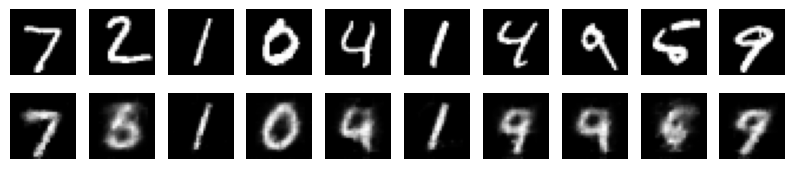

Test loss / Epoch,█▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
Train loss / Epoch,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Test loss / Epoch,0.17369
Train loss / Epoch,0.17382


Latent space - 30, Number of CL - 3
29343
Epoch 1, Train loss: 0.16856, Test loss: 0.06266
Epoch 2, Train loss: 0.05138, Test loss: 0.04185
Epoch 3, Train loss: 0.03802, Test loss: 0.03400
Epoch 4, Train loss: 0.03322, Test loss: 0.03078
Epoch 5, Train loss: 0.03074, Test loss: 0.02888
Epoch 6, Train loss: 0.02914, Test loss: 0.02732
Epoch 7, Train loss: 0.02796, Test loss: 0.02632
Epoch 8, Train loss: 0.02705, Test loss: 0.02581
Epoch 9, Train loss: 0.02640, Test loss: 0.02506
Epoch 10, Train loss: 0.02582, Test loss: 0.02478
Epoch 11, Train loss: 0.02539, Test loss: 0.02436
Epoch 13, Train loss: 0.02472, Test loss: 0.02368
Epoch 14, Train loss: 0.02442, Test loss: 0.02395
Epoch 15, Train loss: 0.02417, Test loss: 0.02307
Epoch 16, Train loss: 0.02388, Test loss: 0.02323
Epoch 17, Train loss: 0.02365, Test loss: 0.02280
Epoch 18, Train loss: 0.02348, Test loss: 0.02284
Epoch 19, Train loss: 0.02329, Test loss: 0.02240
Epoch 20, Train loss: 0.02310, Test loss: 0.02221
Finished Training

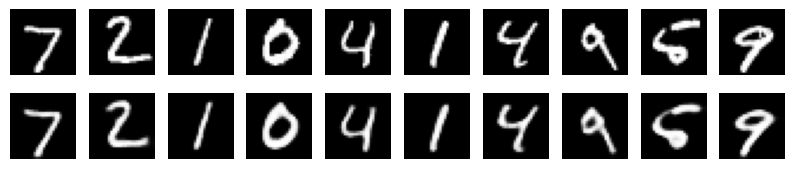

Test loss / Epoch,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Train loss / Epoch,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test loss / Epoch,0.02221
Train loss / Epoch,0.0231


In [18]:
batch_size = 50

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
for d in [2, 30]:  
  model = AutoEncoder(d).to(device)
  # init logging service W&B
  init_wb()
  wandb.config.d = d
  wandb.config.CL = 3
  print(f"Latent space - {d}, Number of CL - 3")
  # print the number of learning parameters
  print(sum(p.numel() for p in model.parameters() if p.requires_grad))
  # define loss and optimizer
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=1e-5)
  # train
  train_net()
  # visualize
  plot_autoencoder_outputs(model, testloader, device)
  wandb.finish()
  # save model
  torch.save(model.state_dict(), PATH + f'{d}.pt')

## Interpolation 

Digits - 4, 7
d = 2


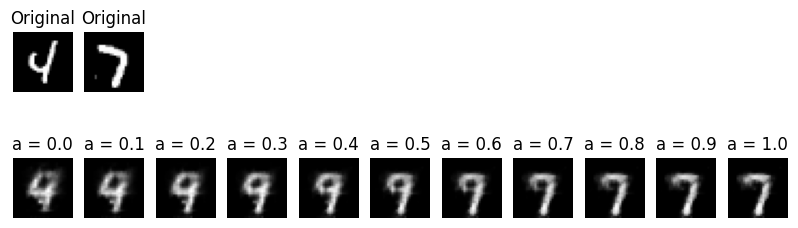

d = 8


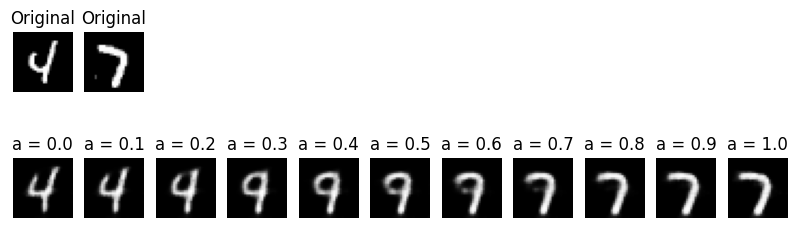

d = 14


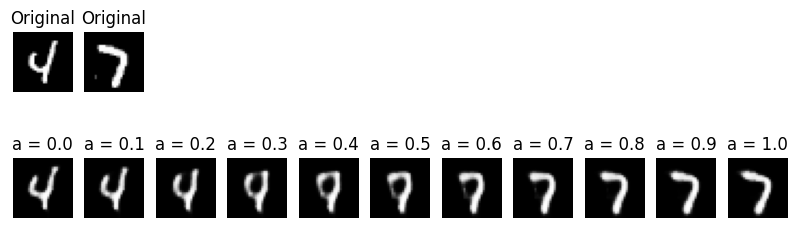

d = 30


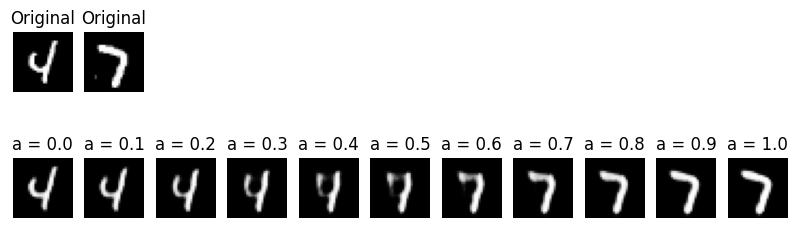





Digits - 8, 9
d = 2


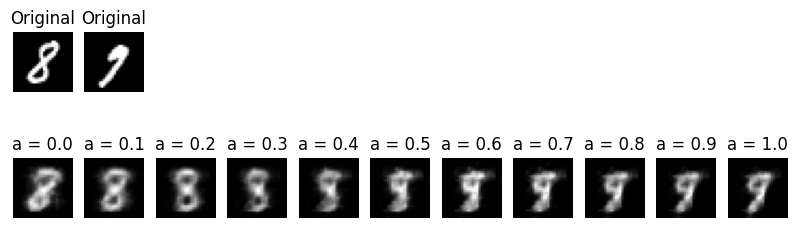

d = 8


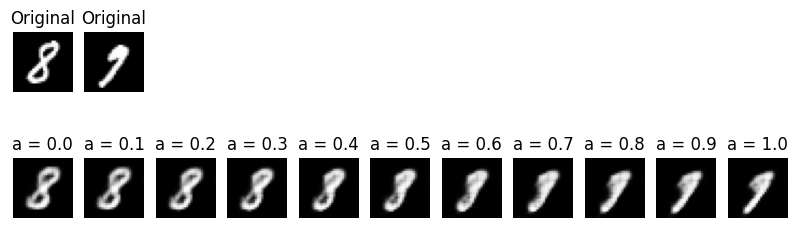

d = 14


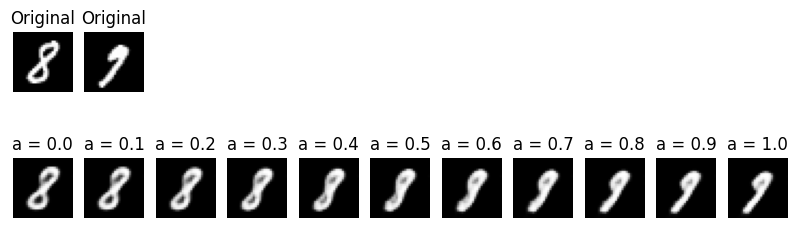

d = 30


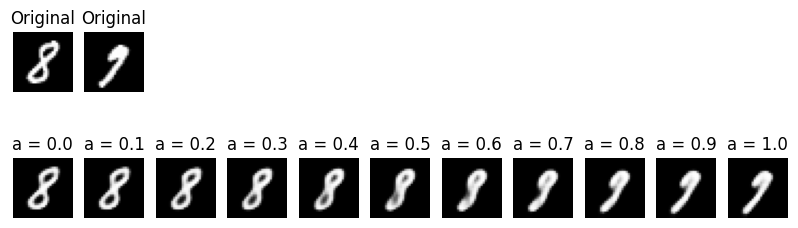





Digits - 3, 4
d = 2


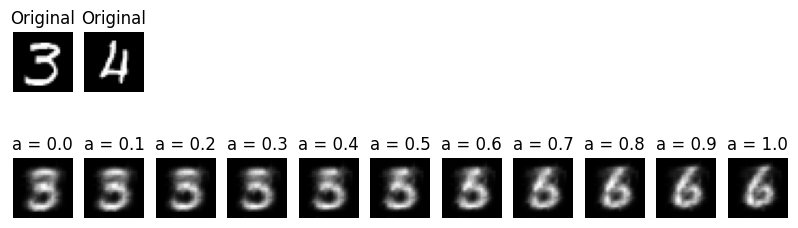

d = 8


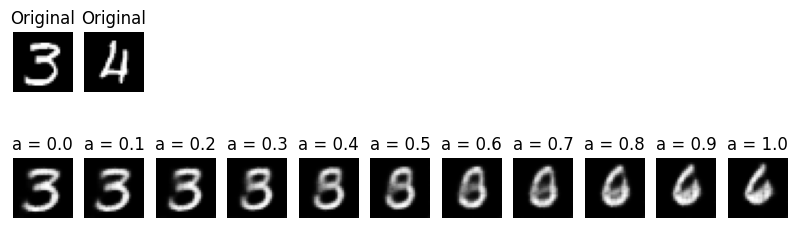

d = 14


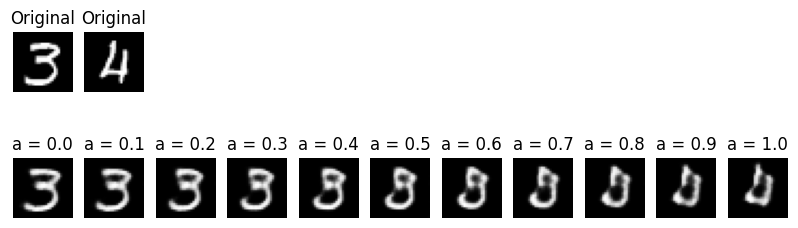

d = 30


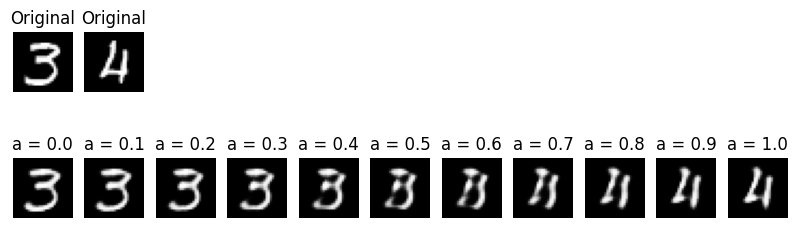





Digits - 8, 3
d = 2


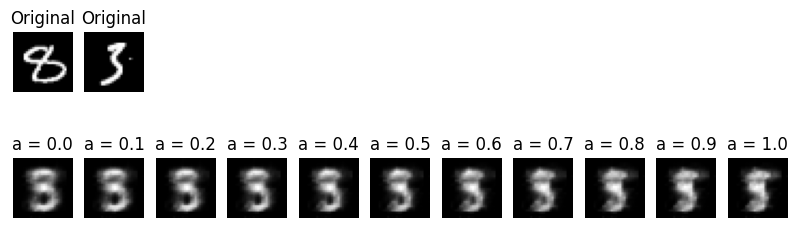

d = 8


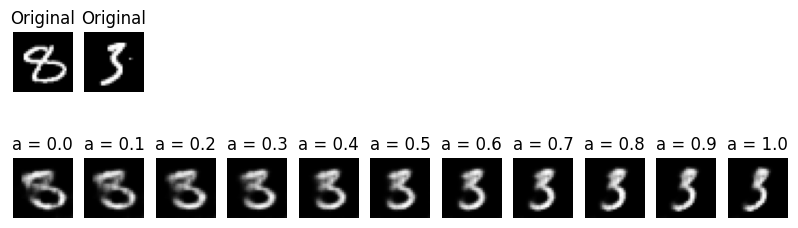

d = 14


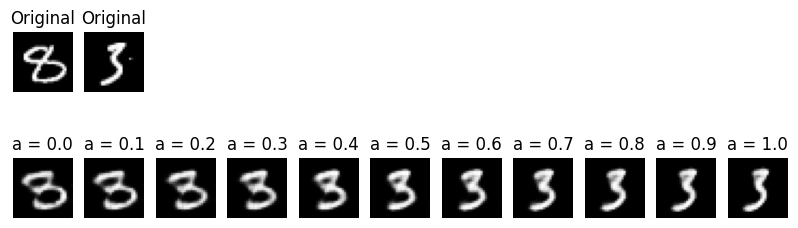

d = 30


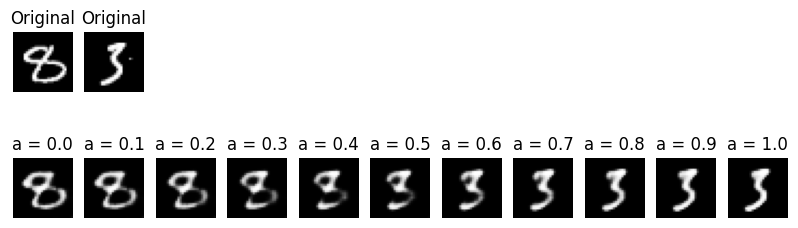





Digits - 5, 1
d = 2


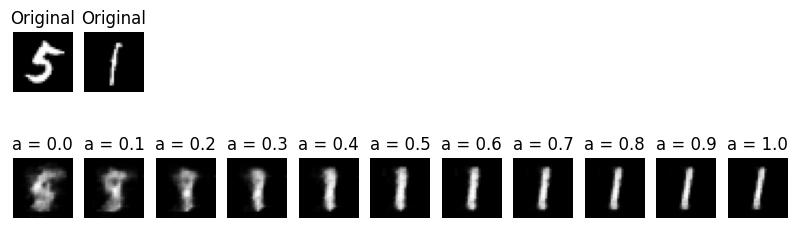

d = 8


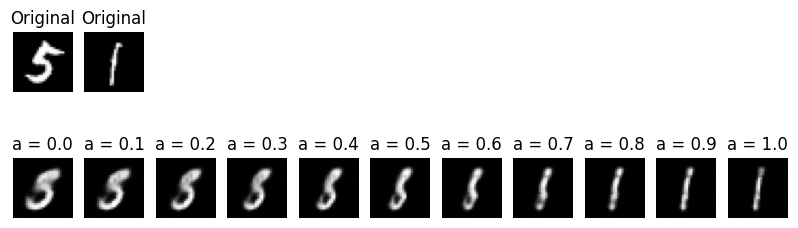

d = 14


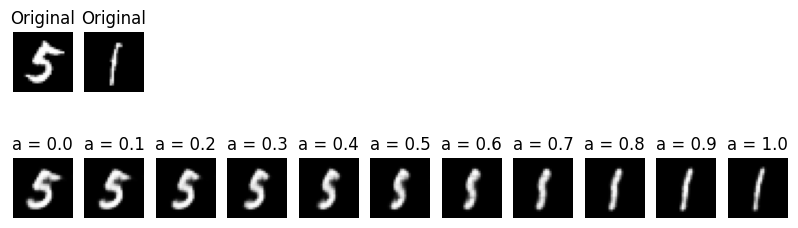

d = 30


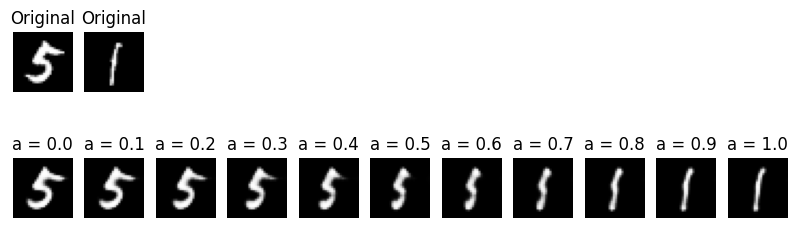

In [15]:
batch_size = 50

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
for _ in range(5):
  digit1, digit2, label1, label2 = get_two_images(trainloader)
  print(f'Digits - {label1[0]}, {label2[0]}')
  for d in [2, 8, 14, 30]:
      print(f'd = {d}')
      # load model
      model = AutoEncoder(d)
      model.load_state_dict(torch.load(PATH + f'{d}.pt'))
      model.eval()

      # interpolate digits
      interpolate_digits(model, digit1, digit2)

  print('\n\n\n')

## Decorrelation

Correlation for d=2 is 0.5814872304805815
Correlation for d=6 is 0.3335574610165847
Correlation for d=8 is 0.3092565789825784
Correlation for d=10 is 0.29023031955925155
Correlation for d=12 is 0.2445463691826861
Correlation for d=14 is 0.233035662319964
Correlation for d=30 is 0.14765687363622582


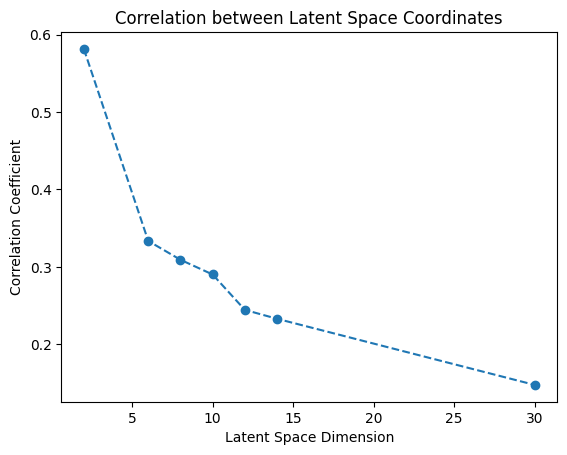

In [31]:
from scipy.stats import pearsonr

batch_size=5000

# define a new DataLoader for different batch size
decorrelationloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)
correlations = []

for d in dims:
    model = AutoEncoder(d)
    model.load_state_dict(torch.load(PATH + f'{d}.pt'))
    with torch.no_grad():
        images, _ = next(iter(decorrelationloader))
        encoded_images = model.encoder(images).numpy()
    
    corr_matrix = np.corrcoef(encoded_images, rowvar=False)
    # compute the abs mean correlation coefficient across all off-diagonal elements
    off_diagonal_indices = np.triu(corr_matrix, k=1).astype(int)
    corr_coef = np.mean(np.abs(corr_matrix[off_diagonal_indices]))
    correlations.append(corr_coef)
    print(f'Correlation for d={d} is {corr_coef}')

# plot the results
plt.plot(dims, correlations, 'o--')
plt.xlabel("Latent Space Dimension")
plt.ylabel("Correlation Coefficient")
plt.title("Correlation between Latent Space Coordinates")
plt.show()


## Transfer Learning

In [16]:
class EncoderPlusMLP(nn.Module):
    def __init__(self, encoder, latent_space, num_classes=10):
        super().__init__()
        self.encoder = encoder
        self.fc1 = nn.Linear(latent_space, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x


In [32]:
def accuracy(model, testloader):
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)
          # calculate outputs by running images through the network
          outputs = model(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  return 100 * correct // total


def train(model, criterion, optimizer, trainloader, epochs):
    data = next(iter(trainloader))
    images, labels = data[0].to(device), data[1].to(device)
    for epoch in range(epochs):
      train_loss = 0.0
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    return train_loss / len(labels)

def test(model, testloader):
    test_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()

    return test_loss / len(testloader)

In [34]:
criterion = nn.CrossEntropyLoss()
testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=False)
lr=1e-3
epochs=20
fixed_encoder, full_net = [], []
for d in dims:
  for batch_size in [20, 40, 80, 160]:
      trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=False)
      # fixed pre trined encoder
      pretrained = AutoEncoder(d)
      pretrained.load_state_dict(torch.load(PATH + f'{d}.pt'))
      model = EncoderPlusMLP(pretrained.encoder, d).to(device)
      model.encoder.train(False)
      optimizer = optim.SGD(model.parameters(), lr)
      train(model, criterion, optimizer, trainloader, epochs)
      acc = accuracy(model, testloader)
      fixed_encoder.append(acc)
      wandb.log({"Test Loss": test(model, testloader),
                 "Accuracy": acc})
      print(f"Fixed Encoder, Batch size - {batch_size}, Latent space - {d} " + f'Accuracy of the network on the test images: {acc} %')

      # non fixed pre trined encoder
      pretrained = AutoEncoder(d)
      pretrained.load_state_dict(torch.load(PATH + f'{d}.pt'))
      model = EncoderPlusMLP(pretrained.encoder, d).to(device)
      optimizer = optim.SGD(model.parameters(), lr)
      train(model, criterion, optimizer, trainloader, epochs)
      acc = accuracy(model, testloader)
      full_net.append(acc)
      wandb.log({"Test Loss": test(model, testloader),
                 "Accuracy": acc})
      print(f"Full Network, Batch size - {batch_size}, Latent space - {d} " + f'Accuracy of the network on the test images: {acc} %')
  
  print("\n")

print(f'Fixed Encoder Mean Acc - {np.mean(fixed_encoder)}, Full Network Mean Acc - {np.mean(full_net)}')
      


      # init_wb()
      # wandb.config.update({
      #     "batch size": batch_size,
      #     "d": d,
      #     "epochs": 10,
      #     "architecture": "MLP",
      #     "#neurons": sum(p.numel() for p in model.parameters() if p.requires_grad)
      # })

Fixed Encoder, Batch size - 20, Latent space - 2 Accuracy of the network on the test images: 11 %
Full Network, Batch size - 20, Latent space - 2 Accuracy of the network on the test images: 13 %
Fixed Encoder, Batch size - 40, Latent space - 2 Accuracy of the network on the test images: 7 %
Full Network, Batch size - 40, Latent space - 2 Accuracy of the network on the test images: 3 %
Fixed Encoder, Batch size - 80, Latent space - 2 Accuracy of the network on the test images: 17 %
Full Network, Batch size - 80, Latent space - 2 Accuracy of the network on the test images: 13 %
Fixed Encoder, Batch size - 160, Latent space - 2 Accuracy of the network on the test images: 15 %
Full Network, Batch size - 160, Latent space - 2 Accuracy of the network on the test images: 7 %


Fixed Encoder, Batch size - 20, Latent space - 6 Accuracy of the network on the test images: 10 %
Full Network, Batch size - 20, Latent space - 6 Accuracy of the network on the test images: 8 %
Fixed Encoder, Batch size